In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from scipy.stats import skew
from scipy.special import boxcox1p
import lightgbm as lgb

In [2]:
def select_feature(train, y_train, percent):
    from sklearn.ensemble import RandomForestClassifier   
    max_feature = int(len(train.columns) / 2 + 1)
    xgb_clas = xgb.XGBClassifier()       
    xgb_clas.fit(train , y_train.astype('int'))    
    feature_importances = pd.DataFrame(xgb_clas.feature_importances_,
                                       index = train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)   
    feature_importances = feature_importances.head(int(len(feature_importances)*(percent/100)))
    plt.plot(feature_importances["importance"])   
    head_list = feature_importances.index.values.tolist()   
    return  head_list

In [3]:
def fill_na_by_condition(df, col, method):
    if method == "empty":
        if df[col].dtypes == "object":
            df[col] = df[col].fillna("None")
        else: 
            df[col] = df[col].fillna(0)            
    if method == "other":
        null_percent = (df[col].isnull().sum() / len(df[col])) * 100
        zero_percent = (len(df[col][all_data[col] == 0]) / len(df[col])) * 100
        mode_data = df[col].mode()[0]       
        if df[col].dtypes == "object":           
            df[col] = df[col].fillna(mode_data)          
        else:         
            if mode_data > 0:
                df[col] = df[col].fillna(mode_data)
            else:
                fill = (1 - zero_percent / 100) * df[col].mean()
                df[col] = df[col].fillna(mode_data) 

In [4]:
def remove_null_data_and_fill_na(df):  
    remove_columns_list = []    
    for col in df:
        if col != "SalePrice":
            if df[col].isnull().sum(axis = 0) > 0:                
                mis_per = round((df[col].isnull().sum() / len(df[col]) *100),2)       
                if mis_per > 45.:
                    print("remove:", col)
                    df = df.drop(col, axis=1)
                    remove_columns_list.append(col)
                else:
                    fill_na_by_condition(df, col, "other")     
    return df  

In [5]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [6]:
def pic_fun(df, SalePrice):    
    i = 0
    fig = plt.figure(figsize=(30, 30))
    for col in df:
        result = re.match("\w*_",col)
        if not result:
            if i % 16 == 0:
                fig = plt.figure(figsize=(30, 30))
            if df[col].dtypes != "object":            
                i = i % 16   
                ax = fig.add_subplot(4, 4, i+1)
                ax.scatter(df[col], SalePrice)         
                ax.set_title(col, fontsize=18)
                i += 1

In [7]:
def process_outlier(df, column_data):
    for k,v in column_data.items():
        if k in df:
            df = df[(df[k]) < v]
    return df 

In [8]:
def rmsle_cv(model, x, y, n_folds=4):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x)
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = kf))
    return np.mean(rmse)

In [9]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [10]:
data_url = "/home/jovyan/courses/ML/Part3/Chapter9/house_prices_regression/"
test = pd.read_csv(data_url + "test.csv")  
train = pd.read_csv(data_url + "train.csv") 
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [11]:
# train = train[(train["SalePrice"]) < 500000]
# ax = sns.distplot(train["SalePrice"])

In [12]:
train["SalePrice"] = np.log1p(train["SalePrice"])
# ax = sns.distplot(train["SalePrice"])

In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na.sort_values(ascending=False).head(20)
all_data = remove_null_data_and_fill_na(all_data)

remove: Alley
remove: Fence
remove: FireplaceQu
remove: MiscFeature
remove: PoolQC


In [15]:
print(all_data.shape)
#prcoess categorical type
colls = ["YrSold", "MoSold", "YearBuilt", "GarageYrBlt", "YearRemodAdd", "MSSubClass", "ExterQual", "ExterCond"
        ,"BsmtQual","BsmtCond", "BsmtExposure", "", "BsmtFinType2", "HeatingQC", "CentralAir","KitchenQual",
        "GarageQual", "GarageCond", "PavedDrive"] 
for c in colls:
    if c in all_data:
        lbl = LabelEncoder() 
        lbl.fit(list(all_data[c].values)) 
        all_data[c] = lbl.transform(list(all_data[c].values))        

(2919, 74)


In [16]:
all_data["MoSold"].head()

0     1
1     4
2     8
3     1
4    11
Name: MoSold, dtype: int64

In [17]:
# numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(10)
# skewness = skewness[abs(skewness) > 0.75]
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:   
#     all_data[feat] = boxcox1p(all_data[feat], lam)

In [18]:
print(all_data.shape)
all_data = pd.get_dummies(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]   
print(all_data.shape)
print(test.shape, train.shape)

(2919, 74)
(2919, 231)
(1459, 231) (1460, 231)


before select feature:  (1460, 231) (1459, 231)
after select feature:  (1460, 145) (1459, 145)


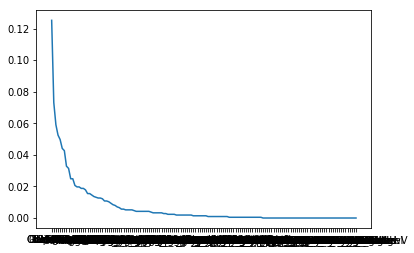

In [19]:
head_feature_list = select_feature(train, y_train, 63)
print("before select feature: ", train.shape, test.shape)
train = train[head_feature_list]
test = test[head_feature_list]
print("after select feature: ", train.shape, test.shape)

(1460, 145) (1460,)


<Figure size 2160x2160 with 0 Axes>

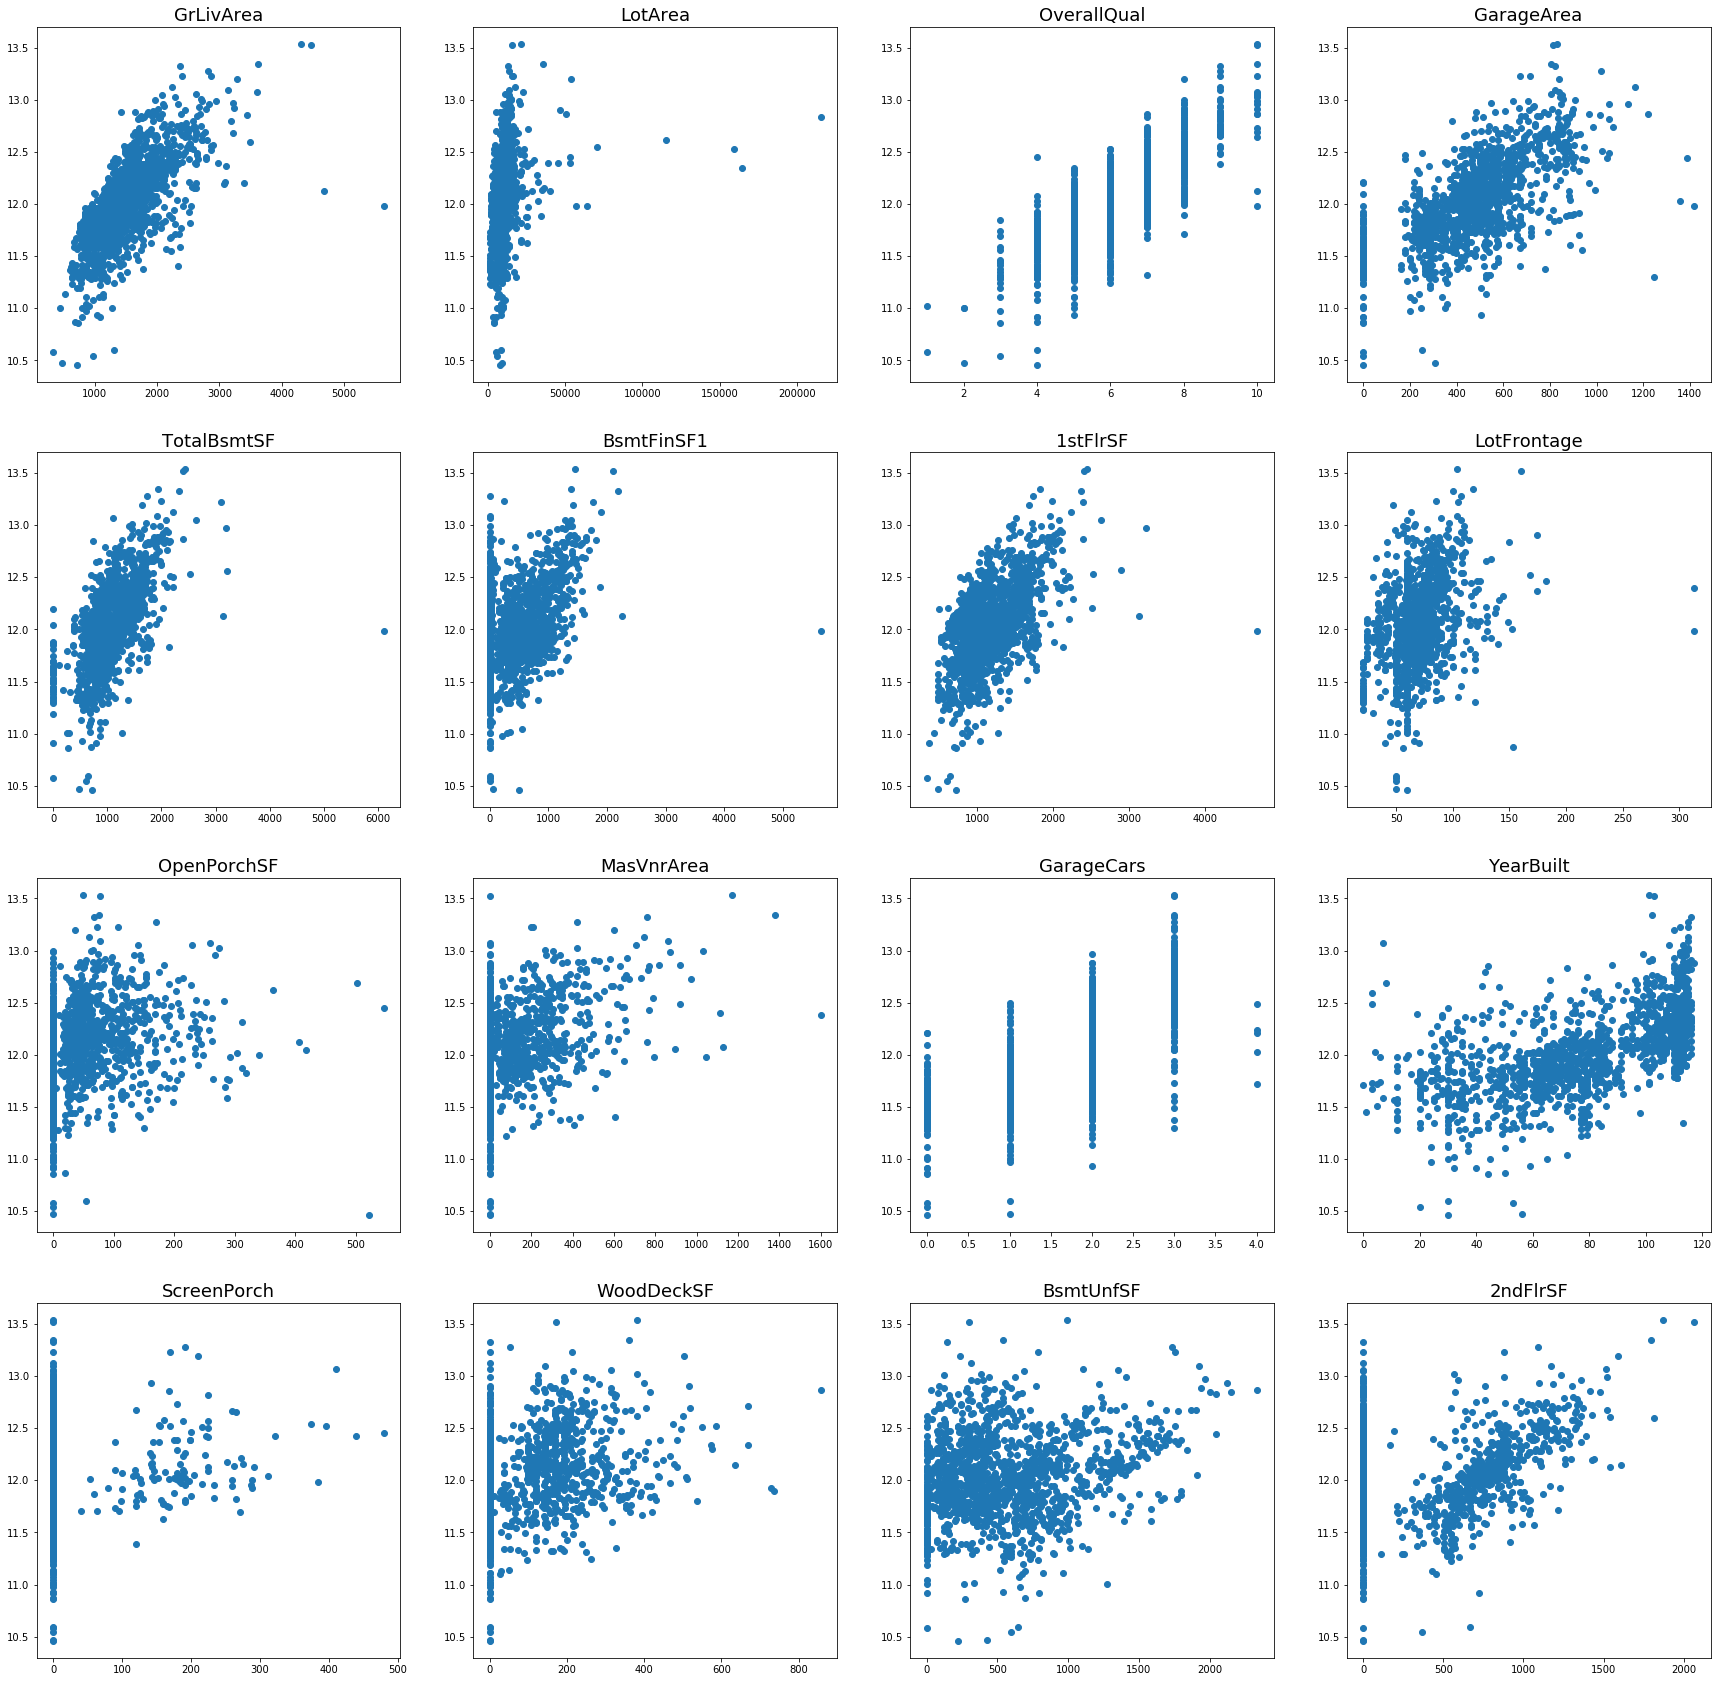

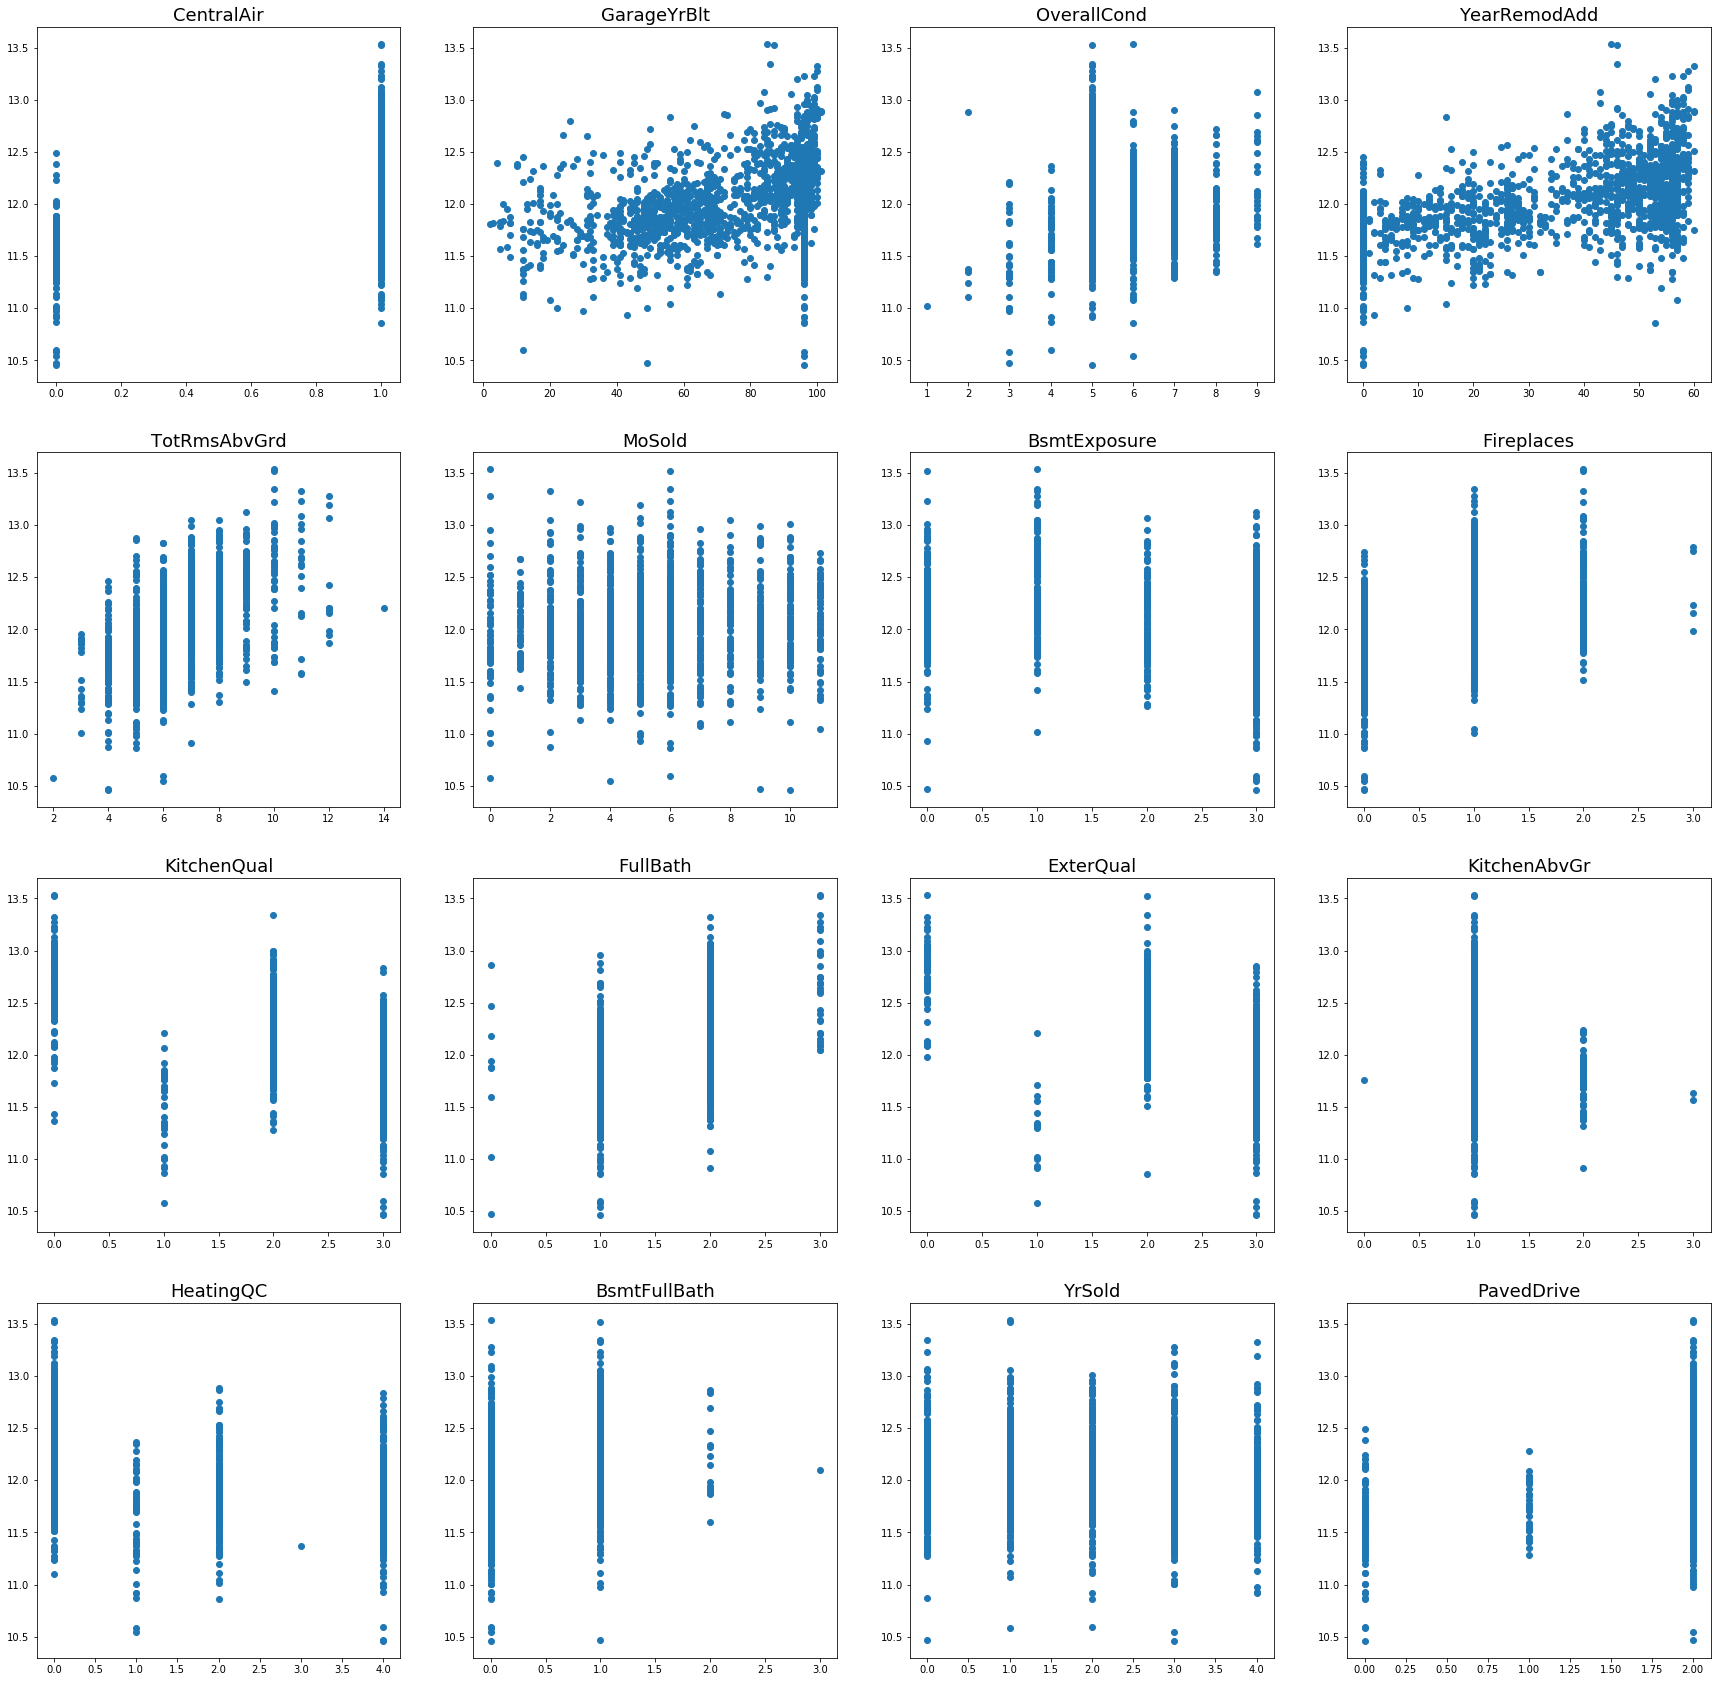

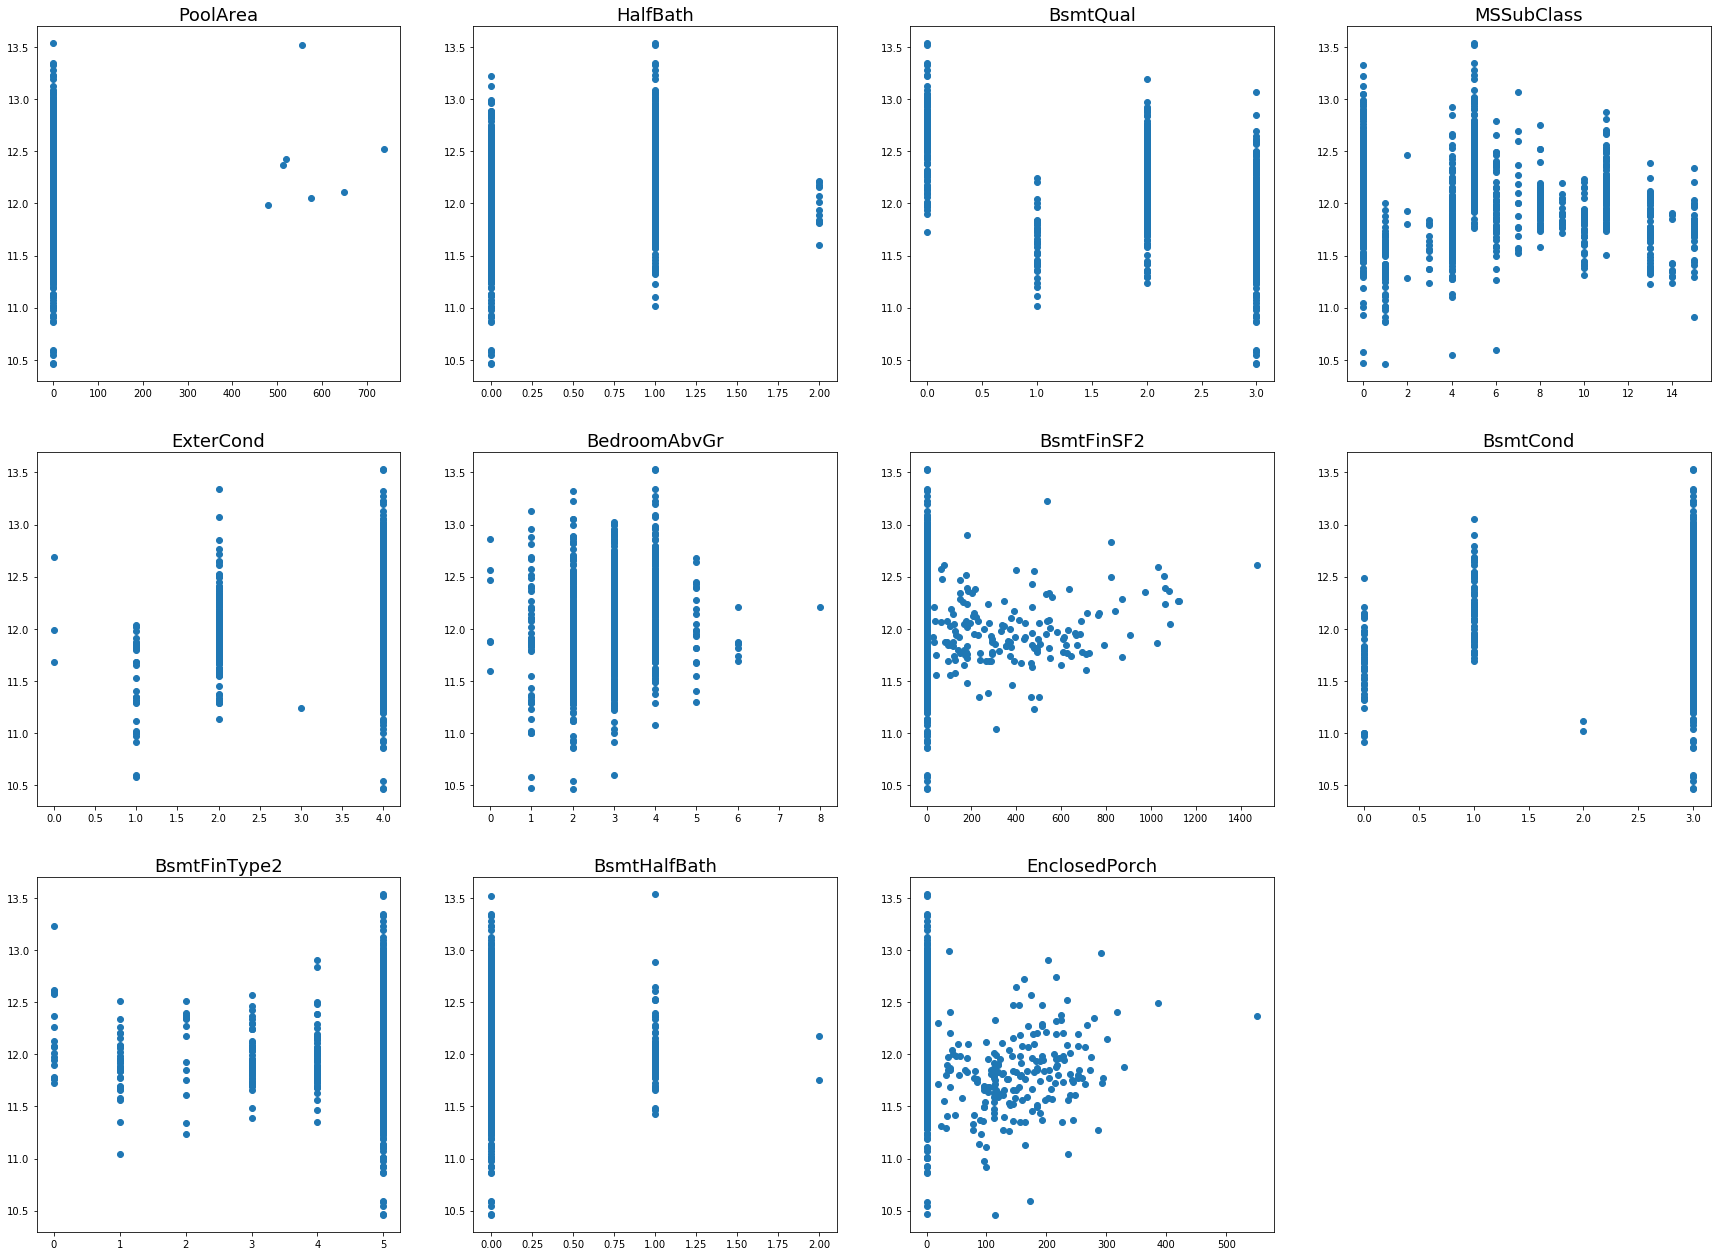

In [20]:
print(train.shape, y_train.shape)
pic_fun(train, y_train)

In [22]:
# train.sort_values(by='EnclosedPorch', ascending=False).head()
train["ScreenPorch"].head()

0    0
1    0
2    0
3    0
4    0
Name: ScreenPorch, dtype: int64

In [21]:
# #outlier process
condition = {
    "1stFlrSF": 2500,
    "2ndFlrSF": 1700,
    "BsmtFinSF1": 5000,
    "BsmtFinSF2": 1200,
    "GrLivArea": 3000,
    "LotArea": 20000,
    "TotalBsmtSF": 2000,
    "EnclosedPorch" : 300,
    "LotFrontage": 200,
    "MasVnrArea": 1500,
    "OpenPorchSF": 300,
    "WoodDeckSF": 500,
    "PoolArea": 100,
    "MasVnrArea": 1300,
    "MiscVal": 2300,
    "GarageArea":1100,
    "LotFrontage":140,
    "MasVnrArea":800,
    "3SsnPorch":330  
}
train["SalePrice"] = y_train
train = process_outlier(train, condition)

(1330, 145)


<Figure size 2160x2160 with 0 Axes>

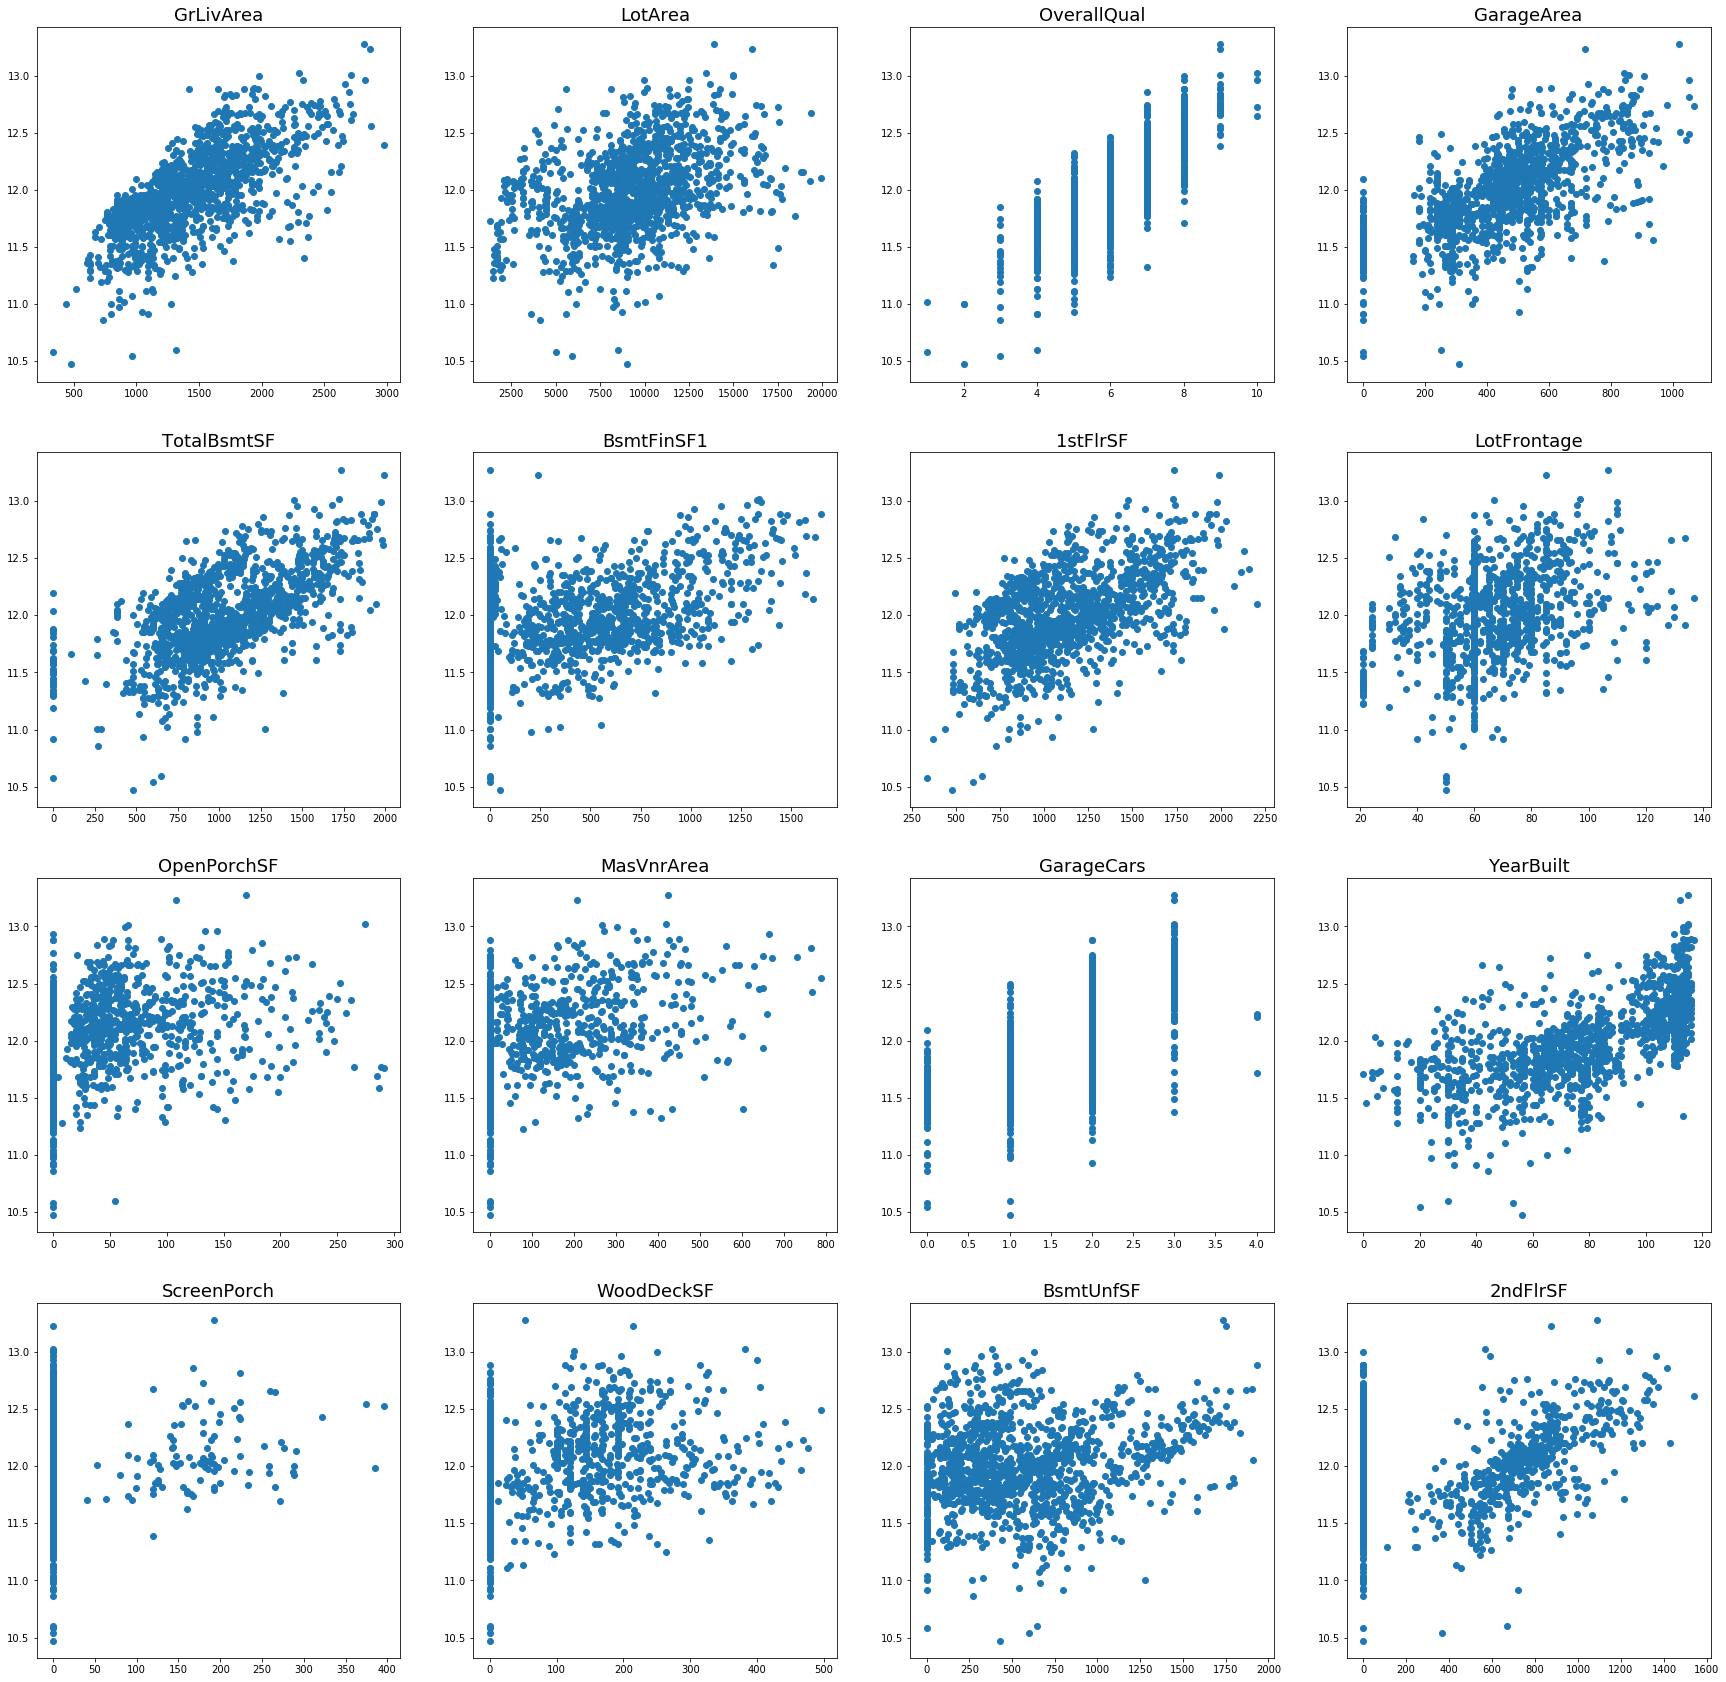

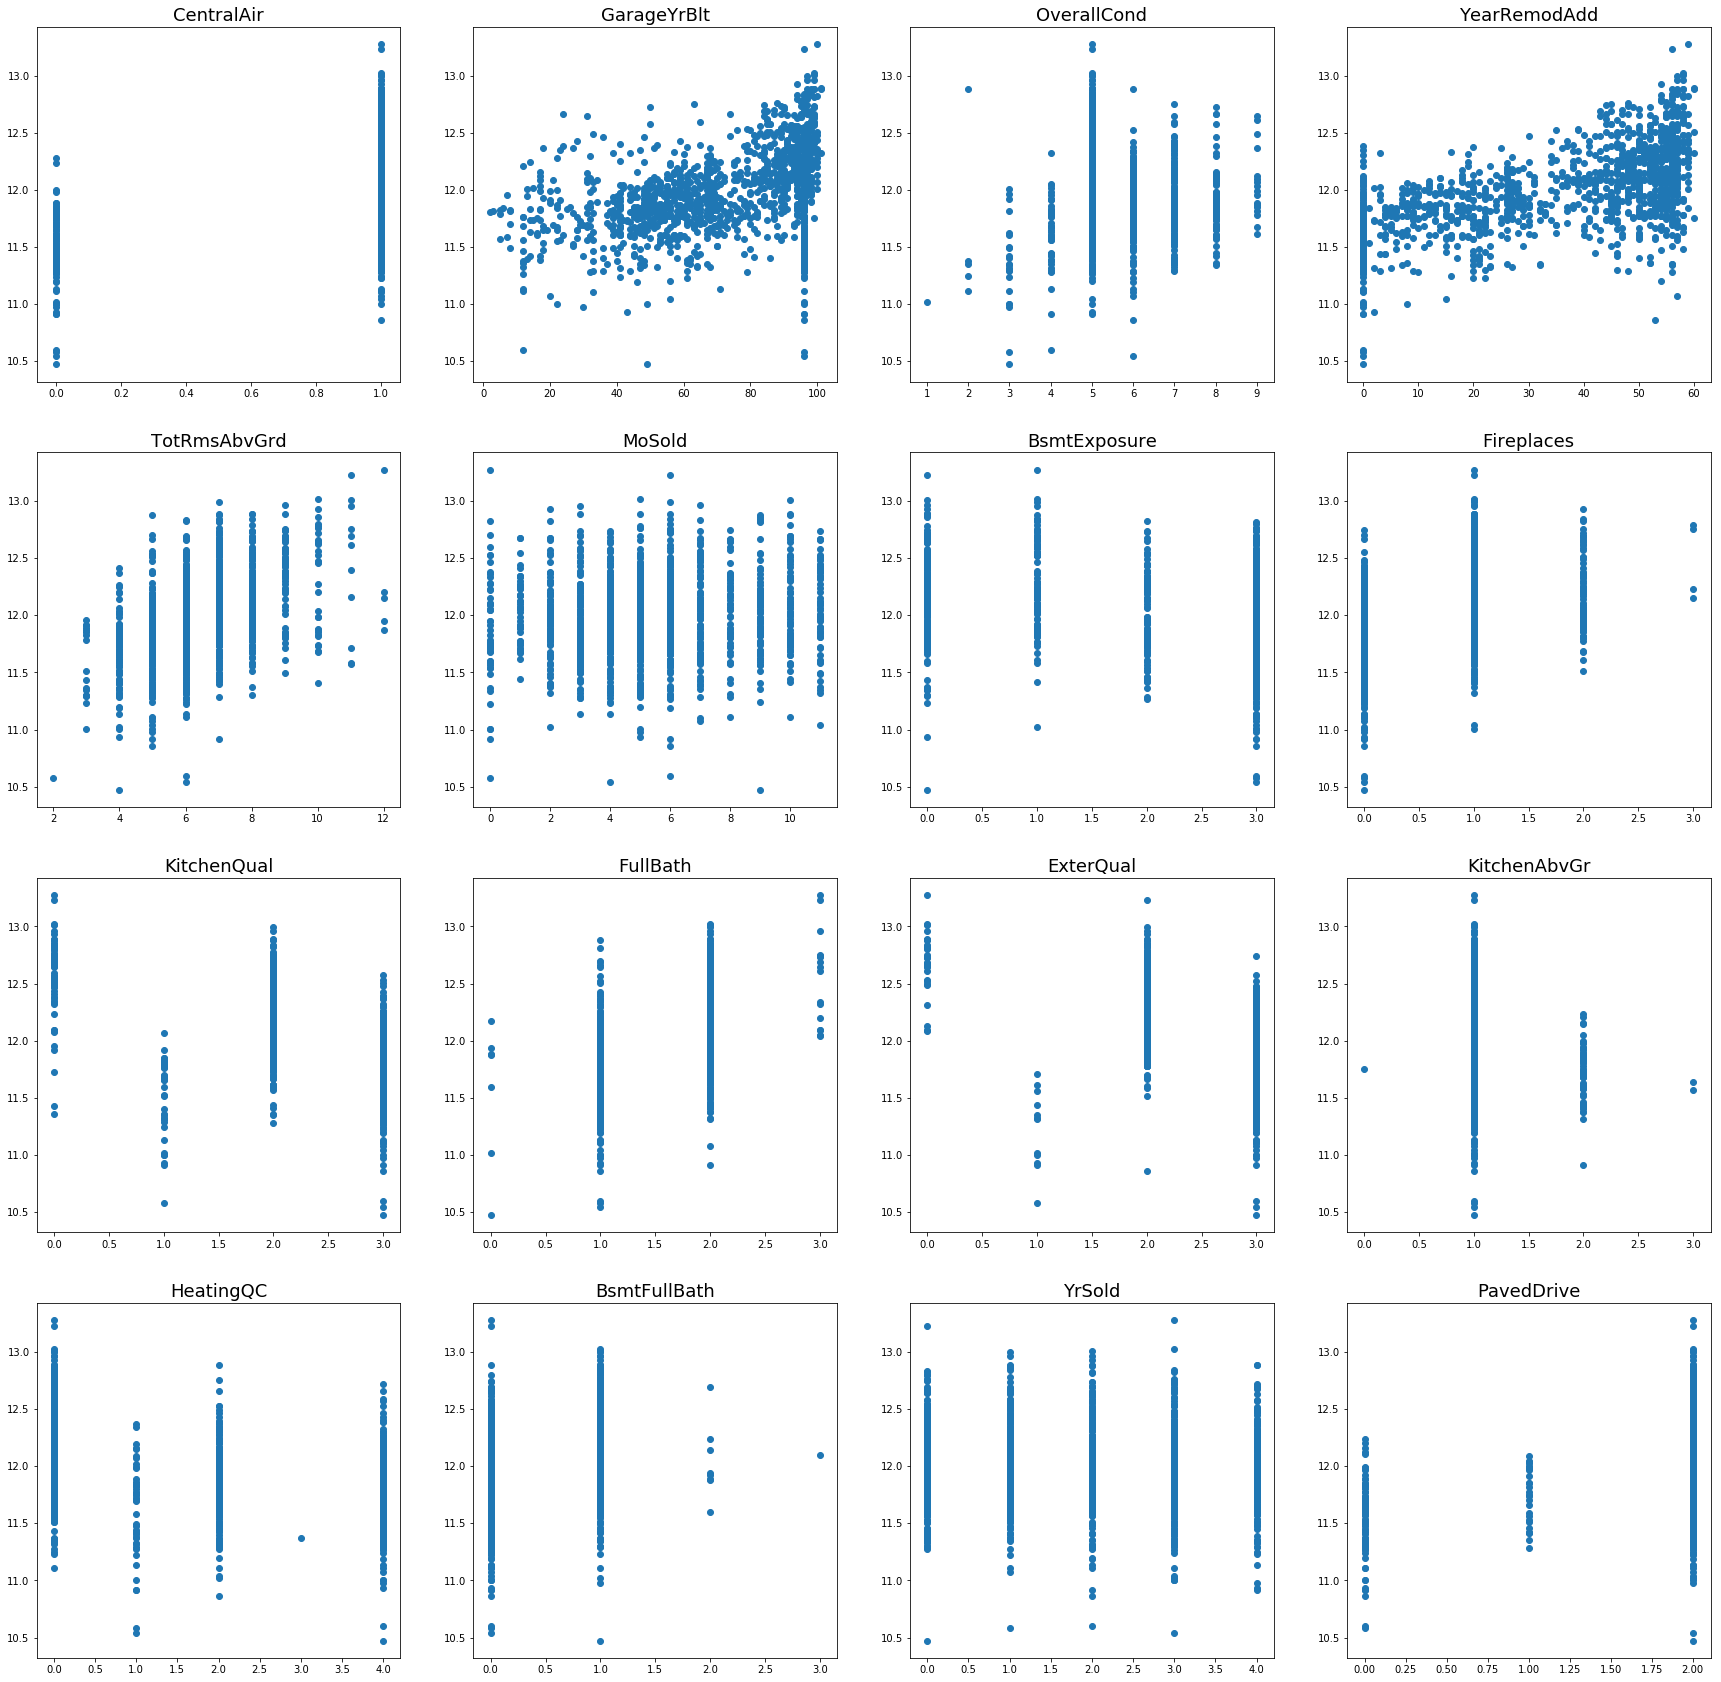

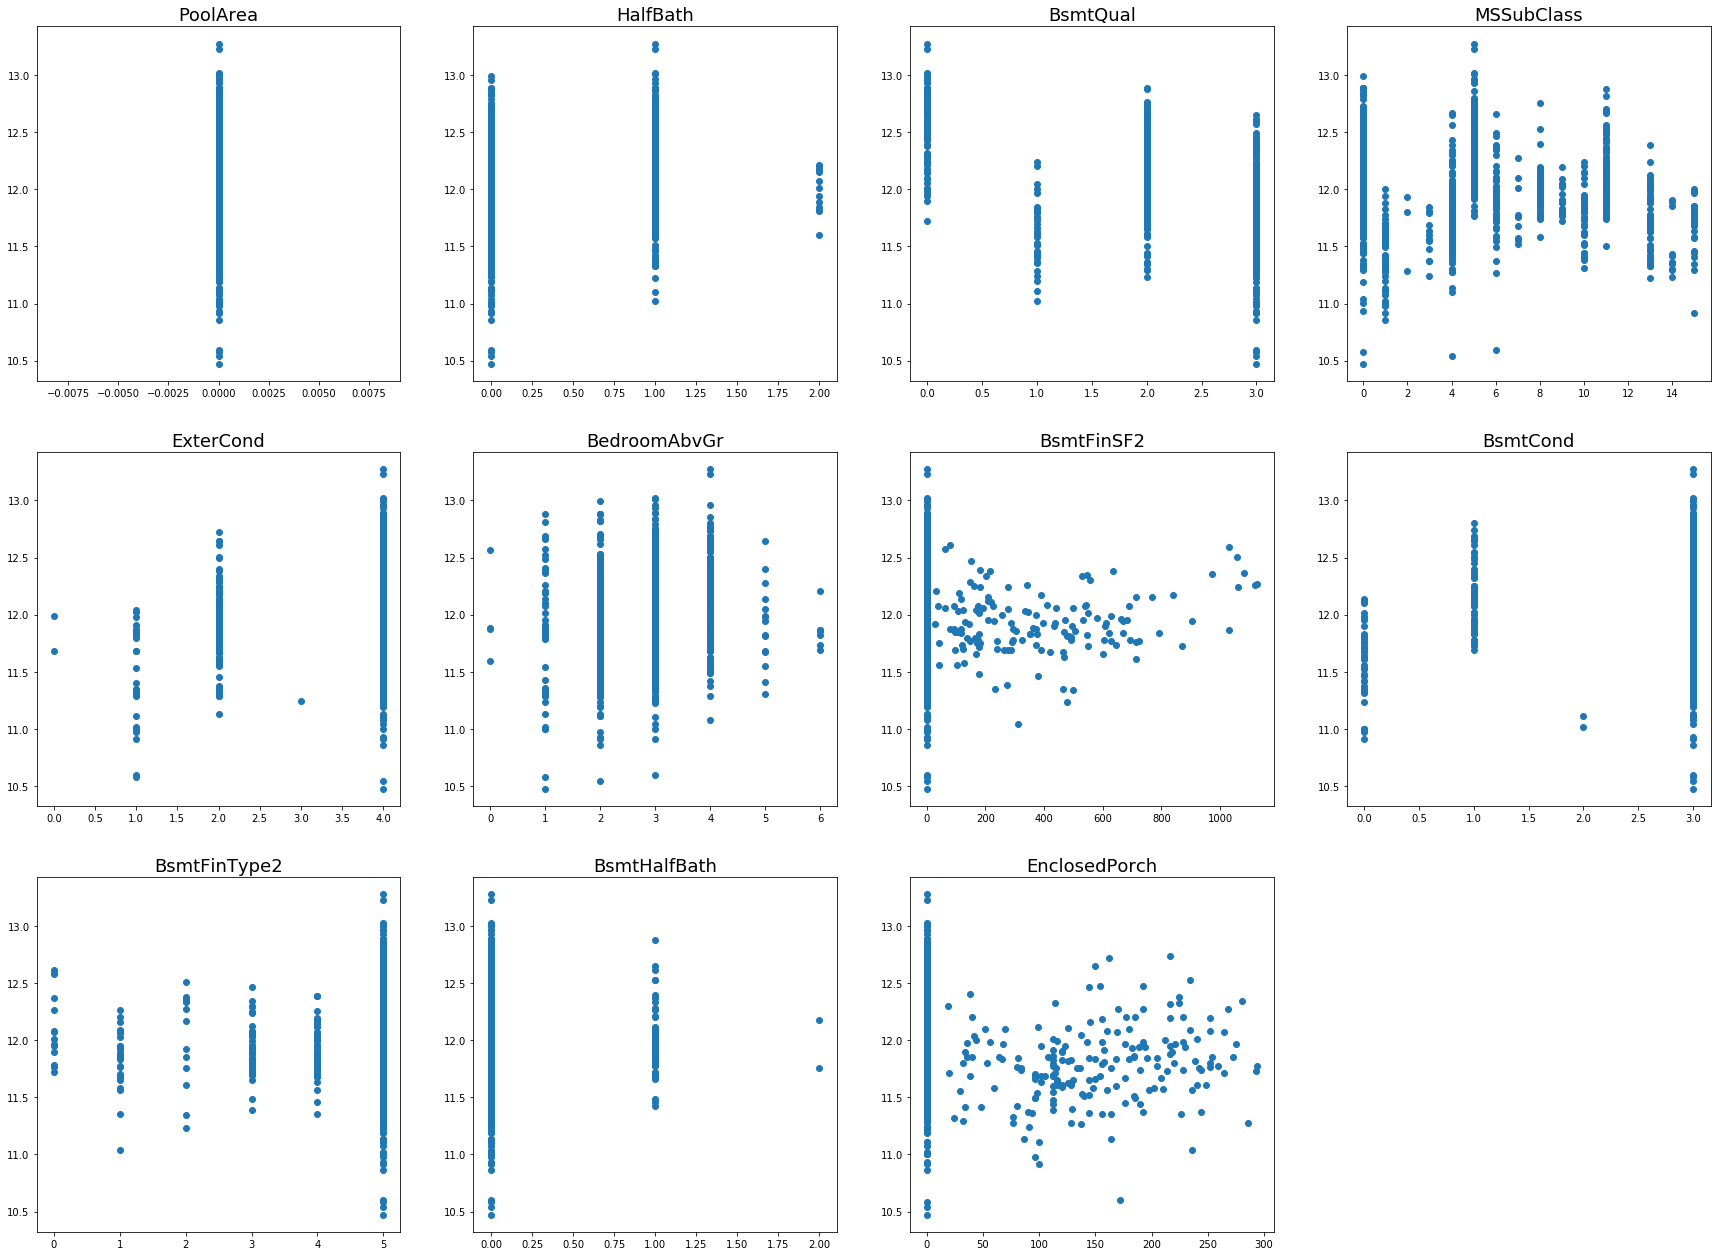

In [22]:
y_train = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)
print(train.shape)
pic_fun(train, y_train)

In [25]:
# for i in range(100, 2000,100):    #1200   
model_xgb = xgb.XGBRegressor(learning_rate=0.04, n_estimators=1200, random_state=1)       
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = model_xgb.predict(test)
xgb_result = rmsle_cv(model_xgb,train, y_train)
print("XGBRegressor train",xgb_result)
xgb_pred = np.expm1(xgb_pred)

XGBRegressor train 0.115246207475


In [26]:
# for i in range(1, 20):
#     i = i / 10000
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0004, random_state=1))
lasso.fit(train, y_train)
lasso_train_pred = lasso.predict(train)
lasso_pred = lasso.predict(test)
lasso_result = rmsle_cv(lasso,train, y_train)
print("lasso train",lasso_result)
lasso_pred = np.expm1(lasso_pred)

lasso train 0.108285134554


In [27]:
# for i in range(1, 20):
#     i = i / 10
eNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=1))
eNet.fit(train, y_train)
eNet_train_pred = eNet.predict(train)
eNet_pred = eNet.predict(test)
eNet_result = rmsle_cv(eNet,train, y_train)
print("eNet train",eNet_result)
eNet_pred = np.expm1(eNet_pred)

eNet train 0.108300957479


In [28]:
# for i in range(1, 20):  
krr = KernelRidge(alpha=0.1, kernel='polynomial', degree=1, coef0=4)
krr.fit(train, y_train)
krr_train_pred = krr.predict(train)
krr_pred = np.expm1(krr.predict(test))
krr_result = rmsle_cv(krr,train, y_train)
print("krr train", krr_result)
krr_pred = krr_pred

krr train 0.109550974011


In [29]:
# for i in range(500,3000,100):
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.05, n_estimators=600)
model_lgb.fit(train, y_train)
model_lgb_train_pred = model_lgb.predict(train)
model_lgb_pred = model_lgb.predict(test)
model_lgb_result = rmsle_cv(model_lgb,train, y_train)
print("lgb train", model_lgb_result)
model_lgb_pred = np.expm1(model_lgb_pred)

lgb train 0.123019882737


In [30]:
#### 0.109405218546
#0.109314560244
#0.108516122072
#0.107927000702 ==> 0.11771
#0.107085899724
#
result = xgb_result * 0.1 + lasso_result * 0.35  + eNet_result * 0.35 + krr_result * 0.2 #+ model_lgb_result * 0.2
all_result = xgb_pred * 0.1 + lasso_pred * 0.35  + eNet_pred * 0.35 + krr_pred * 0.2 #+ model_lgb_pred * 0.2
# result = lasso_result * 0.33  + eNet_result * 0.34 + krr_result * 0.33
# all_data = lasso_pred * 0.33  + eNet_pred * 0.34 + krr_pred * 0.33
print(result)

0.109239947761


In [31]:
# pd.DataFrame({'Id': test_ID, 'SalePrice': all_result }).to_csv('2018-08-16_2 .csv', index =False)